# BUILDING_KNOWLEDGE_GRAPH

## Entities Extraction (THEORY)
The extraction of a single word entity from a sentence can be done with the help of parts of speech (POS) tags. The nouns and the proper nouns would be our entities.

However, when an entity spans across multiple words, then POS tags alone are not sufficient. We need to parse the dependency tree of the sentence.

Let’s get the dependency tags of a sentence:

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

doc = nlp("The 22-year-old recently won ATP Challenger tournament.")

for tok in doc:
  print(tok.text, "-->",tok.dep_,"-->", tok.pos_)

The --> det --> DET
22-year --> npadvmod --> NUM
- --> punct --> PUNCT
old --> nsubj --> ADJ
recently --> advmod --> ADV
won --> ROOT --> VERB
ATP --> compound --> PROPN
Challenger --> compound --> PROPN
tournament --> dobj --> NOUN
. --> punct --> PUNCT


### Modifier Words
The subject (nsubj) in this sentence as per the dependency parser is “old”. That is not the desired entity. We wanted to extract “22-year-old” instead.

The dependency tag of “22-year” is amod which means it is a modifier of “old”. Hence, we should define a rule to extract such entities.

The rule can be something like this —

 **Extract the subject/object along with its modifiers and also extract the punctuation marks between them.**

### Compound Words
But then look at the object (dobj) in the sentence. It is just “tournament” instead of “ATP Challenger tournament”. Here, we don’t have the modifiers but compound words.

Compound words are those words that collectively form a new term with a different meaning.  Its a combination of multiple words linked to form a word with a new meaning (example – “Football Stadium”, “animal lover”).Therefore, we can update the above rule to ⁠— 

**Extract the subject/object along with its modifiers, compound words and also extract the punctuation marks between them.**

We will use dependency parsing to extract entities.

## Extract Relations

To build a knowledge graph, we need edges to connect the nodes (entities) to one another. These edges are the relations between a pair of nodes.


Extracting relation from a sentence:

In [ ]:
doc = nlp("The 22-year-old recently won ATP Challenger tournament.")

for tok in doc:
  print(tok.text, "-->",tok.dep_,"-->", tok.pos_)

The --> det --> DET
22-year --> npadvmod --> NUM
- --> punct --> PUNCT
old --> nsubj --> ADJ
recently --> advmod --> ADV
won --> ROOT --> VERB
ATP --> compound --> PROPN
Challenger --> compound --> PROPN
tournament --> dobj --> NOUN
. --> punct --> PUNCT


To extract the relation, we have to find the ROOT of the sentence (which is also the verb of the sentence). Hence, the relation extracted from this sentence would be “won”.




# Building a Knowledge Graph from Text Data

We will build a knowledge graph from scratch by using the text from a set of movies and films related to Wikipedia articles. 
 

In [ ]:
# Import Libraries
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [ ]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("/content/drive/My Drive/Colab Notebooks/QARIK_placement_project/learning_stage_and_references/input/wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [ ]:
candidate_sentences['sentence'].sample(5)

219                         actress elsa lanchester portrayed the monster's bride.
3402                                                      i refuse to approach it.
2111    the cinematic adaptation of a clockwork orange  was not initially planned.
132                                 principal photography began on august 1, 2011.
3598                    it consists of an outer cubical shell  and the inner cube.
Name: sentence, dtype: object

# Entity Pairs Extraction (Subject, Object)

To build a knowledge graph, the most important things are the nodes and the edges between them.

These nodes are going to be the entities that are present in the Dataset sentences. Edges are the relationships connecting these entities to one another. We will extract these elements in an unsupervised manner, i.e., we will use the grammar of the sentences.

The main idea is to go through a sentence and extract the subject and the object as and when they are encountered. However, there are a few challenges ⁠— an entity can span across multiple words.

So, I have created a function below to extract the subject and the object (entities) from a sentence. I have partitioned the code into multiple sections and explained seperately:

In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

Explaining the code chunks in the function above:

* **Chunk 1**

I have defined a few empty variables in this chunk. prv_tok_dep and prv_tok_text will hold the dependency tag of the previous word in the sentence and that previous word itself, respectively. prefix and modifier will hold the text that is associated with the subject or the object.

* **Chunk 2**

Next, we will loop through the tokens in the sentence. We will first check if the token is a punctuation mark or not. If yes, then we will ignore it and move on to the next token. If the token is a part of a compound word (dependency tag = “compound”), we will keep it in the prefix variable.

As and when we come across a subject or an object in the sentence, we will add this prefix to it. We will do the same thing with the modifier words, such as “nice shirt”, “big house”, etc.

* **Chunk 3**

Here, if the token is the subject, then it will be captured as the first entity in the ent1 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will be reset.

* **Chunk 4**

Here, if the token is the object, then it will be captured as the second entity in the ent2 variable. Variables such as prefix, modifier, prv_tok_dep, and prv_tok_text will again be reset.

* **Chunk 5**

Once we have captured the subject and the object in the sentence, we will update the previous token and its dependency tag.

Let’s test this function on a sentence:

In [ ]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [ ]:
get_entities("NI assembly approves to build a water treatment plant near Belfast")

['NI assembly', 'water treatment Belfast']

In the above sentence, ‘NI assembly’ is the subject and ‘water treatment Belfast’ is the object.

Now we can use this function to extract these entity pairs for all the sentences in our whole dataset:

In [ ]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:44<00:00, 97.10it/s] 


The list entity_pairs contains all the subject-object pairs from the Wikipedia:

In [ ]:
entity_pairs[0:20]

[['connie', 'own'],
 ['later  woman', 'distance'],
 ['christian', 'then  elder'],
 ['temple', 'fire'],
 ['outside  cult', 'him'],
 ['it', 'religious  awakening'],
 ['c. mackenzie', 'craig cast'],
 ['later craig di francia', 'action cast'],
 ['sebastian  maniscalco', 'later paul ben cast'],
 ['we', 'just  film'],
 ['we', 'tests'],
 ['m global', 'international sales rights'],
 ['robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['', 'military  arrest'],
 ['train', 'vuk'],
 ['telepath', 'gallio'],
 ['singer', 'men']]

As you can see, there are a few pronouns in these entity pairs such as ‘we’, ‘it’, ‘she’, etc. We’d like to have proper nouns or nouns instead. We can  improve the model to filter out pronouns. (needs to be implemented in future)

# Relation / Edge Extraction

Relation/Edge is actually the main verb in a sentence.

For example, in the sentence – “Sixty Hollywood musicals were released in 1929”, the verb is “released in” and this is what we are going to use as the Relation/Edge for the triple generated from this sentence.

The model below captures the relation/predicate from a sentence. Used spaCy’s rule-based matching:

In [ ]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

The pattern defined in the function tries to find the ROOT word or the main verb in the sentence. Once the ROOT is identified, then the pattern checks whether it is followed by a preposition (‘prep’) or an agent word. If yes, then it is added to the ROOT word.
Lets try out some examples:

In [ ]:
get_relation("John completed the task")

'completed'

In [ ]:
get_relation("NI assembly approves to build a water treatment plant near Belfast")

'approves'

Similarly, let’s get the relations from all the Dataset sentences:

In [ ]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:42<00:00, 101.85it/s]


Let’s take a look at the most frequent relations or predicates that we have just extracted:

In [ ]:
pd.Series(relations).value_counts()[:50]

is               370
was              297
released on       87
include           73
are               71
were              71
released          40
's                38
composed by       35
has               31
became            31
have              31
become            29
released in       27
included          26
produced          22
called            22
made              20
had               20
considered        20
be                18
been              18
scheduled         17
used              17
stars             16
directed by       16
written by        15
hired             14
wrote             14
produced by       14
set               14
introduced in     13
went              13
received          13
wanted            12
began in          11
won               11
began             11
sold              10
gave              10
features          10
reported           9
known as           9
includes           9
gives              9
directed           9
produced in        9
opened       

# Build a Knowledge Graph

We will finally create a knowledge graph from the extracted entities (subject-object pairs) and the predicates/edges (relation between entities).

Let’s create a dataframe of entities/nodes and predicates/edges:

In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

## KNOWLEDGE-GRAPH (NETWORKX LIBRARY)

In [ ]:
import networkx as nx

Next, we will use the networkx library to create a network from this dataframe. The nodes will represent the entities and the edges or connections between the nodes will represent the relations between the nodes.

It is going to be a directed graph.

In [ ]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

Let’s plot the network:

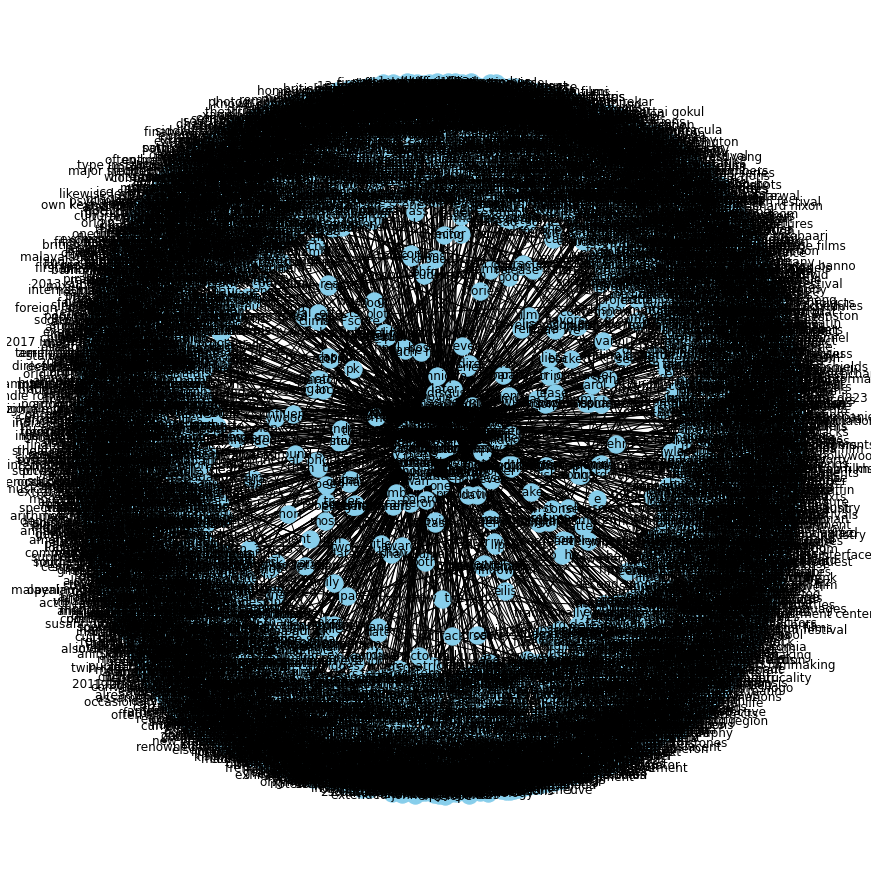

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

It turns out that we have created a graph with all the relations that we had. It becomes really hard to visualize a graph with these many relations.

So, lets use one relation at a time to visualize our Knowledge-Graph. Let’s start with the relation “composed by”:

## FILTERING KNOWLEDGE GRAPH

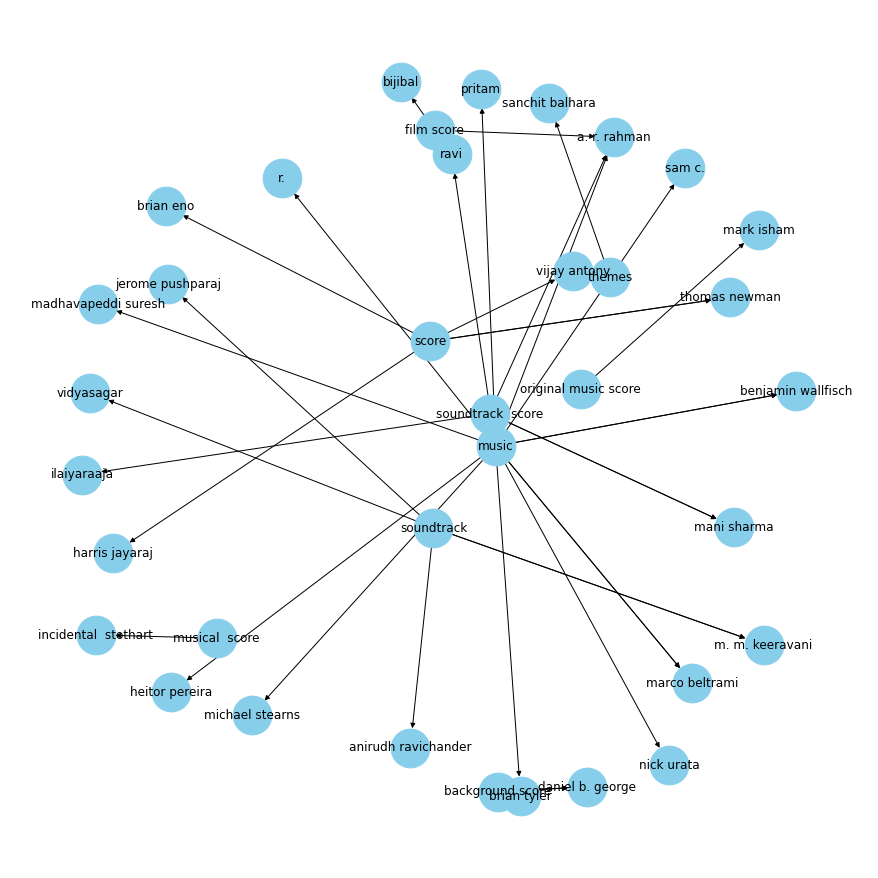

In [ ]:
# RELATION = "composed by"
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

That’s a much cleaner graph. Here the arrows point towards the composers. For instance, A.R. Rahman, who is a renowned music composer, has entities like “soundtrack score”, “film score”, and “music” connected to him in the graph above.

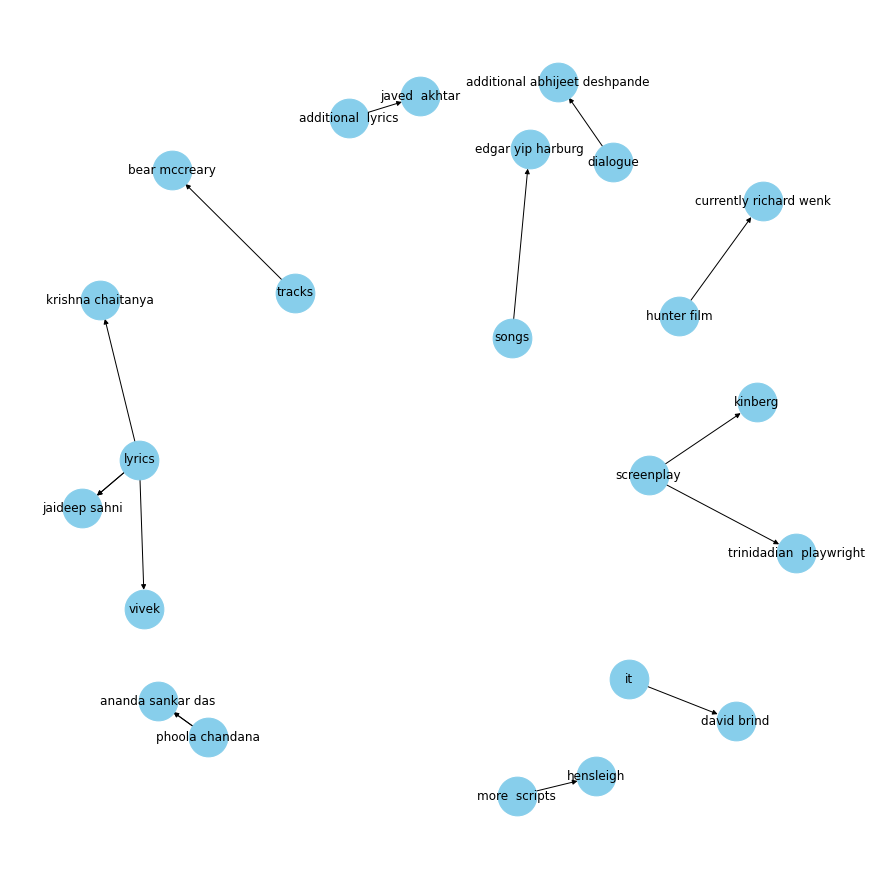

In [ ]:
# RELATION = "written by"
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

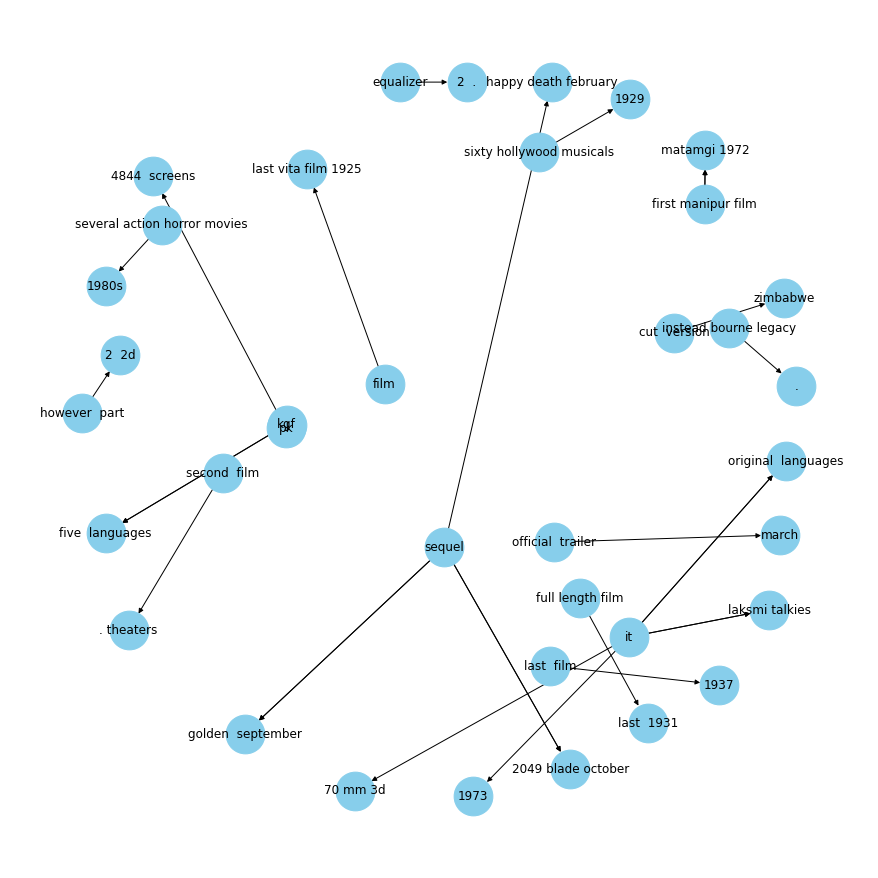

In [ ]:
# RELATION = "released in"
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

W can see quite a few interesting information in this graph. For example, look at this relationship – “several action horror movies released in the 1980s” and “pk released on 4844 screens”. Similarly we can filter out useful information using a knowledge graph.